## preparation and initialisation

In [1]:
# loading libraries 
from mesa import Model, Agent                 # uses mesa (unsure if I actually do), for documentation see https://mesa.readthedocs.io/latest/
from mesa.space import NetworkGrid             
from mesa.datacollection import DataCollector

import networkx as nx                         # for network stuff
import numpy as np                            # 
from matplotlib import pyplot as plt  
import pandas as pd
import random

# intitialising graph
adj_matrix = pd.read_csv('/home/dot/random_coding/modeling_article/synthetic_edges.csv', index_col= 0 )
#print(adj_matrix)
adj_matrix.columns = adj_matrix.columns.astype(int)
G = nx.from_pandas_adjacency(adj_matrix)

# adding social support
nodes = pd.read_csv('/home/dot/random_coding/modeling_article/synthetic_nodes.csv')
soc_sup_dict = dict(zip(nodes['ID'], nodes['SOC_SUP']))
nx.set_node_attributes(G, soc_sup_dict, "social support")

## initial checks to see if everything looks as it should

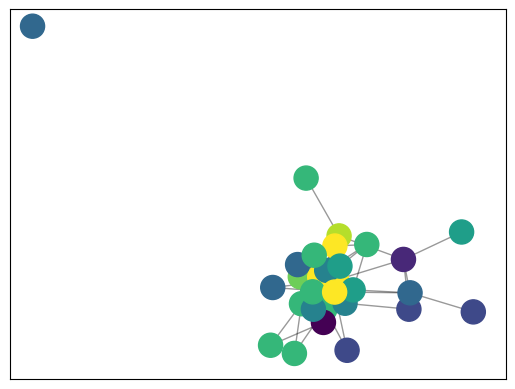

In [2]:
# preliminary visualisation
soc_sup = nx.get_node_attributes(G, "social support")
node_colors = [soc_sup[node] for node in G.nodes()]
pos = nx.spring_layout(G, seed=42)

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    cmap=plt.cm.viridis,   # heatmap-style colormap
    node_size=300
)

nx.draw_networkx_edges(G, pos, alpha=0.4)
# social support average and distribution

Average degree: 6.827586206896552
Min degree: 0
Max degree: 15
density: 0.2438423645320197
average clustering: 0.4712553729795109


(array([1., 3., 5., 0., 0., 2., 2., 0., 0., 3., 2., 0., 0., 4., 2., 0., 1.,
        2., 0., 2.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 <BarContainer object of 20 artists>)

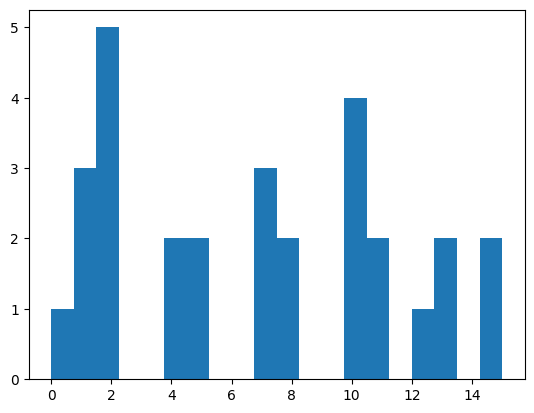

In [3]:
# network statistics
degrees = dict(G.degree())
deg_values = np.array(list(degrees.values()))

print(f"Average degree: {deg_values.mean()}")
print(f"Min degree: {deg_values.min()}")
print(f"Max degree: {deg_values.max()}")
print(f"density: {nx.density(G)}")
print(f"average clustering: {nx.average_clustering(G)}")

#degree distribution:
plt.hist(deg_values, bins=20)

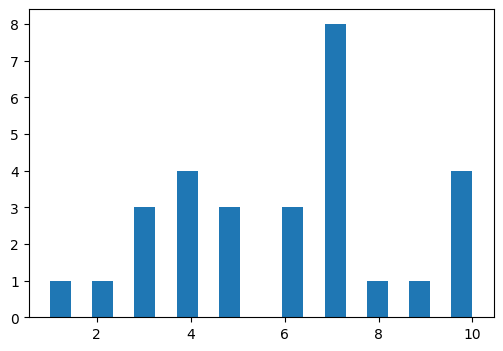

In [4]:
# social support: 
soc_sup = nx.get_node_attributes(G, "social support")
soc_sup_values = np.array(list(soc_sup.values()))

plt.figure(figsize=(6, 4))
plt.hist(soc_sup_values, bins=20)
plt.show()

## Agent Based Model

In [5]:
# initialise each node as agent (with individual level variables)
for n in G.nodes():    
    G.nodes[n]["individual_resilience"] = np.clip(
        np.random.normal(loc=0, scale=0.3), -1, 1
    ) #mean = 0, stddev = 0.3 scale bound by -1 and 1
    
    G.nodes[n]["social support"] = soc_sup[n]  


# define environmental factors (repression, social support is already in it at node level)
G.graph["repression"] = 0.5

# define and initialise variables at group level (resilience, internal social support)
G.graph["internal_social_support"] = 0.2
G.graph["group_resilience"] = 0
G.graph["causes_of_burnout"] = 0.4 

In [6]:
# parameters
dt = 0.01                          # time scale
repression_weight = -0.4           # repression effect on resilience
external_support_weight = 0.015     # external social support effect on individual resilience
internal_support_weight = 0.25      # internal social support effect on micro and meso resilience
support_feedback_weight = 0.1      # weight of the feedback between internal social support and micro/meso resilience
causes_burnout_weight = -0.3      # negative feedback from causes of burnout
resilience_feedback_weight = 0.3   # micro meso feedback

dropout_threshold = -0.7           # resilience threshold for dropping out
join_rate = 0.00                    # base rate for new agents joining
new_agent_connections = 3          # number of connections new agents make
edge_burnout_threshold = -0.3       # above which edge deletion probability > addition


In [7]:
# main loop
def timestep_update(G):
    nodes = list(G.nodes())
    
    # update individual resilience
    internal_support = G.graph["internal_social_support"]
    group_resilience = G.graph["group_resilience"]
    causes_burnout = G.graph["causes_of_burnout"]
    
    for n in nodes:
        if "social support" not in G.nodes[n]:
            print(f"DEBUG: Node {n} has no 'social support' attribute!")
            continue  # or set a default value
        external_support = G.nodes[n]["social support"]  # this stays stable
        
        r_old = G.nodes[n]["individual_resilience"]
        r_new = r_old + dt * (
            repression_weight * G.graph["repression"]
            + external_support_weight * external_support
            + internal_support_weight * internal_support
            + resilience_feedback_weight * group_resilience
            + causes_burnout_weight * causes_burnout
        )
        # Bound between -1 and 1
        G.nodes[n]["individual_resilience"] = np.clip(r_new, -1, 1)
    
    # 2️update group resilience
    micro_mean = np.mean([G.nodes[n]["individual_resilience"] for n in nodes])
    g_old = group_resilience
    g_new = g_old + dt *(
        repression_weight * G.graph["repression"]
        + internal_support_weight * internal_support
        + resilience_feedback_weight * micro_mean
        #+ causes_burnout_weight * causes_burnout
    )
    G.graph["group_resilience"] = np.clip(g_new, -1, 1)

    #update internal social support
    G.graph["internal_social_support"] += support_feedback_weight * G.graph["group_resilience"]
    G.graph["internal_social_support"] = np.clip(G.graph["internal_social_support"], 0, 1)
    
    # update causes of burnout 
    G.graph["causes_of_burnout"] += -0.2 * (micro_mean + G.graph["group_resilience"])
    G.graph["causes_of_burnout"] = np.clip(G.graph["causes_of_burnout"], 0, 1)
    
    # handle agents dropping out
    dropouts = [n for n in nodes if G.nodes[n]["individual_resilience"] < dropout_threshold]
    G.remove_nodes_from(dropouts)
    
    # handle agents joining (not yet functional)
    num_new_agents = int(join_rate * len(G.nodes()) * (1 + G.graph["repression"]))
    if num_new_agents > 0:
        for i in range(num_new_agents):
            new_id = max(G.nodes()) + 1 if len(G.nodes()) > 0 else 1
    
            # sample social support from existing nodes
            existing_ss = [G.nodes[n]["social support"] for n in G.nodes() if "social support" in G.nodes[n]]
            if len(existing_ss) == 0:
                new_soc_sup = 0.5  # fallback if somehow no nodes
            else:
                new_soc_sup = np.random.choice(existing_ss)
    
            # add node with social support and initial resilience
            G.add_node(
                new_id,
                social_support=new_soc_sup,
                individual_resilience=np.clip(np.random.normal(0, 0.3), -1, 1)
            )
    
            # connect to 3 random existing nodes (excluding the new node)
            possible_targets = list(G.nodes())
            possible_targets.remove(new_id)
            if possible_targets:
                targets = random.sample(possible_targets, min(new_agent_connections, len(possible_targets)))
                for t in targets:
                    G.add_edge(new_id, t)
    
    # edge updating for existing agents (not yet functional)
    for n in G.nodes():
        neighbors = set(G.neighbors(n))
        potential_targets = set(G.nodes()) - {n} - neighbors
        # Edge deletion probability increases if individual resilience < threshold
        r_n = G.nodes[n]["individual_resilience"]
        deletion_prob = max(0, (-r_n - edge_burnout_threshold))  # 0 if above threshold
        addition_prob = max(0, 0.1 * r_n + 0.05)  # small base probability
        # Delete edges
        for neighbor in list(neighbors):
            if random.random() < deletion_prob:
                G.remove_edge(n, neighbor)
        # Add edges
        for target in potential_targets:
            if random.random() < addition_prob:
                G.add_edge(n, target)


In [8]:
# running it for n timesteps:
for t in range(20):
    timestep_update(G)

In [9]:
print(G.graph["internal_social_support"])
print(G.graph["group_resilience"])
print(G.graph["causes_of_burnout"])  
print(G.nodes[n]["individual_resilience"])

0.17144404974282507
-0.02771489677663321
0.2749392979049476
0.12827447870823422
